Self-critical sequence training is a technique used in machine learning where a model learns from its own predictions to improve its accuracy over time. It allows the model to focus on areas where it's less confident, refining its predictions by learning from its mistakes.

In [ ]:
!pip install rouge_score

In [ ]:
!pip install rouge

In [ ]:
!pip install torch torchvision torchaudio transformers datasets nltk matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import MarianMTModel, MarianTokenizer
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Sample sentences for demonstration
source_sentences = [
    "Hello, how are you?",
    "What is your name?",
    "I love programming."
]

target_sentences = [
    "नमस्ते, आप कैसे हैं?",
    "आपका नाम क्या है?",
    "मुझे प्रोग्रामिंग पसंद है।"
]

        self.model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-hi")
        self.tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-hi")

In [ ]:
class SiMTModel(nn.Module):
    def __init__(self):
        super(SiMTModel, self).__init__()
        self.model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-hi")
        self.tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-hi")

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask=attention_mask)

    def translate(self, text, wait_k):
        input_ids = self.tokenizer.encode(text, return_tensors='pt')
        output = []
        for i in range(0, len(input_ids[0]), wait_k):
            # Generate tokens for the next wait_k tokens
            next_token = self.model.generate(input_ids=input_ids[:, i:i + wait_k], max_length=50)
            output.append(next_token)
        return torch.cat(output, dim=1)

In [ ]:
def train_model(model, source_sentences, target_sentences, epochs=25, wait_k_values=[1, 2, 3]):
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    for epoch in range(epochs):
        for source, target in zip(source_sentences, target_sentences):
            input_ids = model.tokenizer.encode(source, return_tensors='pt')
            target_ids = model.tokenizer.encode(target, return_tensors='pt')

            # Greedy translation
            greedy_translation = model.translate(source, wait_k=1)
            greedy_translation_text = model.tokenizer.decode(greedy_translation[0], skip_special_tokens=True)

            # Sampled translation
            sampled_wait_k = np.random.choice(wait_k_values)
            sampled_translation = model.translate(source, wait_k=sampled_wait_k)
            sampled_translation_text = model.tokenizer.decode(sampled_translation[0], skip_special_tokens=True)

            # Calculate rewards
            greedy_bleu = sentence_bleu([target.split()], greedy_translation_text.split())
            sampled_bleu = sentence_bleu([target.split()], sampled_translation_text.split())
            reward = sampled_bleu - greedy_bleu  # Reward calculation

            # Update model
            optimizer.zero_grad()

            # Calculate loss based on the target and sampled translation
            # Here we can use a simple negative reward as a loss for demonstration
            loss = -torch.tensor(reward, dtype=torch.float32, requires_grad=True)  # Ensure requires_grad=True

            loss.backward()
            optimizer.step()

            print(f'Epoch: {epoch}, Loss: {loss.item()}, Reward: {reward}')

In [ ]:
from rouge_score import rouge_scorer

def evaluate_model(model, source_sentences, target_sentences):
    bleu_scores = []
    rouge_scores = []

    for source, target in zip(source_sentences, target_sentences):
        translation = model.translate(source, wait_k=1)  # Use optimal wait-k
        translation_text = model.tokenizer.decode(translation[0], skip_special_tokens=True)

        bleu_score = sentence_bleu([target.split()], translation_text.split())
        bleu_scores.append(bleu_score)

        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        rouge_score = scorer.score(target, translation_text)
        rouge_scores.append(rouge_score)

    return bleu_scores, rouge_scores

In [ ]:
def plot_scores(bleu_scores, rouge_scores):
    plt.figure(figsize=(12, 12))

    plt.subplot(1, 2, 1)
    plt.plot(bleu_scores, label='BLEU Score', marker='o')
    plt.title('BLEU Score Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('BLEU Score')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot([r['rouge1'].fmeasure for r in rouge_scores], label='ROUGE-1 Score', marker='o')
    plt.title('ROUGE Score Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('ROUGE Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Train the model
model = SiMTModel()
train_model(model, source_sentences, target_sentences)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: 

Epoch: 0, Loss: -0.0, Reward: 0.0
Epoch: 0, Loss: -0.0, Reward: 2.4057870104519438e-232
Epoch: 0, Loss: -0.0, Reward: 0.0
Epoch: 1, Loss: -0.0, Reward: 2.0015036519810572e-232
Epoch: 1, Loss: -0.0, Reward: 0.0
Epoch: 1, Loss: -0.0, Reward: 2.5739193855298786e-155
Epoch: 2, Loss: -0.0, Reward: 0.0
Epoch: 2, Loss: -0.0, Reward: 2.4057870104519438e-232
Epoch: 2, Loss: -0.0, Reward: 7.592387854259074e-233
Epoch: 3, Loss: -0.0, Reward: 0.0
Epoch: 3, Loss: -0.0, Reward: 2.4057870104519438e-232
Epoch: 3, Loss: -0.0, Reward: 2.5739193855298786e-155
Epoch: 4, Loss: -0.0, Reward: 2.0015036519810572e-232
Epoch: 4, Loss: -0.0, Reward: 0.0
Epoch: 4, Loss: -0.0, Reward: 2.5739193855298786e-155
Epoch: 5, Loss: -0.0, Reward: 0.0
Epoch: 5, Loss: -0.0, Reward: 0.0
Epoch: 5, Loss: -0.0, Reward: 2.5739193855298786e-155
Epoch: 6, Loss: -0.0, Reward: 2.0015036519810572e-232
Epoch: 6, Loss: -0.0, Reward: 2.0088791894285736e-155
Epoch: 6, Loss: -0.0, Reward: 7.592387854259074e-233
Epoch: 7, Loss: 0.0, Reward:

In [ ]:
bleu_scores, rouge_scores = evaluate_model(model, source_sentences, target_sentences)

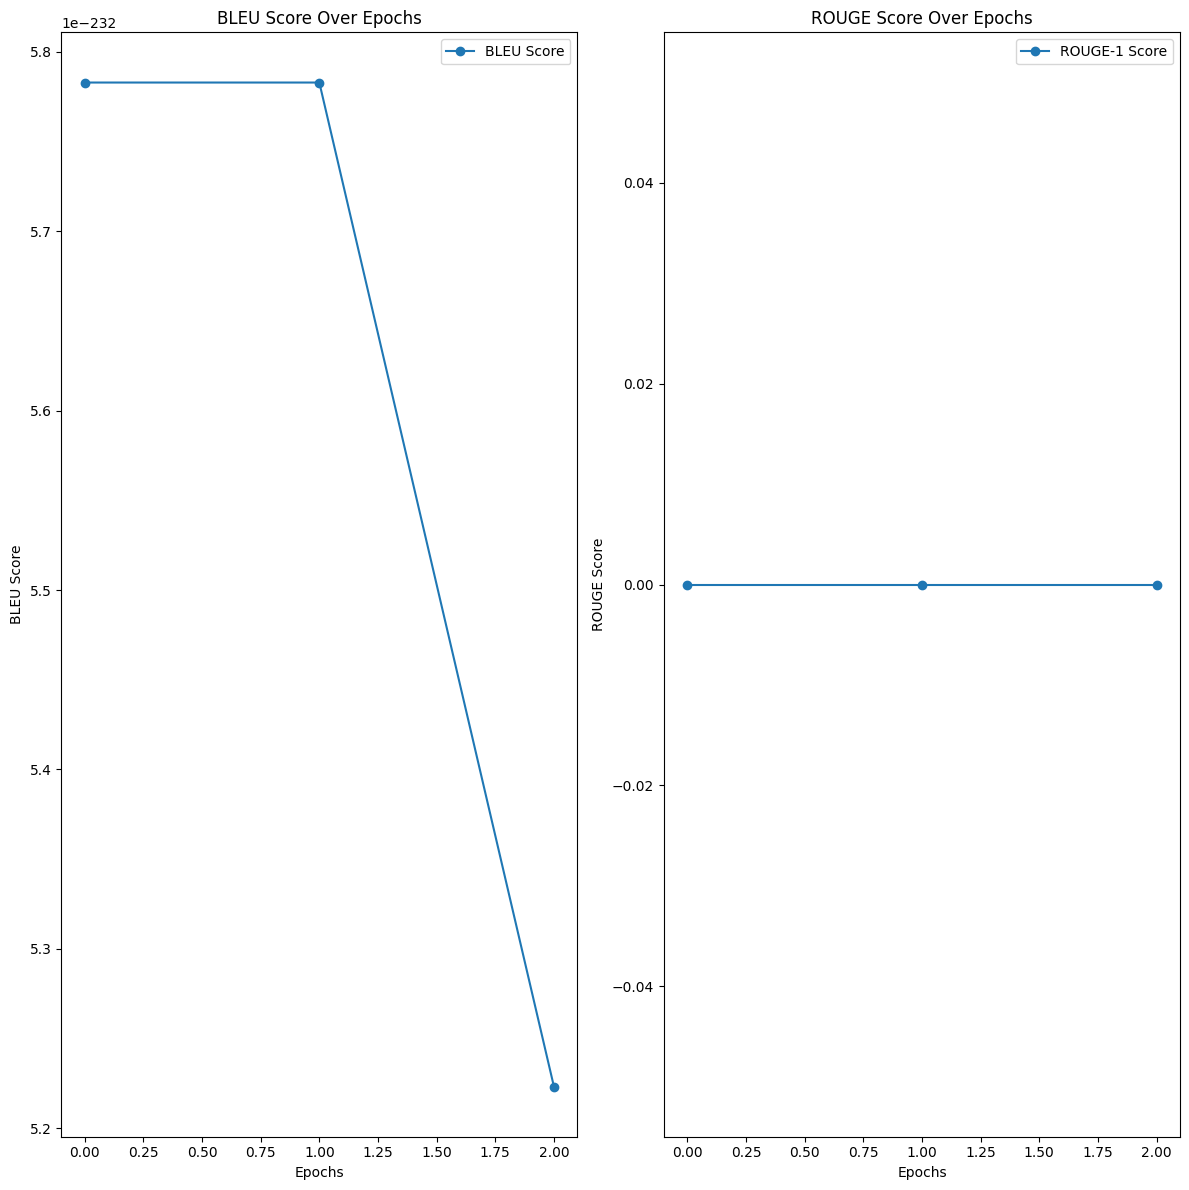

In [ ]:
# Plot the scores
plot_scores(bleu_scores, rouge_scores)



---

